In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import cross_validation, linear_model, preprocessing
from sklearn.metrics import precision_recall_curve, precision_score, recall_score
from __future__ import division
from sklearn import svm
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
from sklearn.cluster import KMeans
%matplotlib inline

In [2]:
raw_data = pd.read_csv('./learndata-latest.csv')
raw_data.head()
crowd_labels = pd.read_csv('./crowdsource-20160208.csv')
crowd_labels.head()
raw_data2 = pd.DataFrame()

True_disagree = 0. 
False_disagree = 0. 

NoConn = sum(raw_data['connected'])
NotConn = len(raw_data) - NoConn + 0. 

for i in range(0,len(crowd_labels)):
    temp = raw_data[raw_data['id_i']==crowd_labels['swi_id'][i]]
    temp2 = temp[temp['id_j']==crowd_labels['swj_id'][i]]
    raw_data2 = raw_data2.append(temp2,ignore_index=True)
    

    if (i%1000==0):
        print i
temp = pd.DataFrame({'Hlab' : raw_data2['connected']})
raw_data2 = pd.concat([temp,raw_data2],axis=1)
raw_data2['connected']=crowd_labels['connected']
raw_data2.head()

# Remove features that we shouldn't learn (encoded geometries and sidewalk ID numbers)
near_line = raw_data2['near_line']  # Save for later
del raw_data2['near_line']
del raw_data2['id_i']
del raw_data2['id_j']

# Binarizes categorical variables 
# (e.g. if 3 categories, makes 3 cols with 1s and 0s)
# X = pd.get_dummies(raw_data)  

# Turn categorical variables into integer labels
label_encoder = preprocessing.LabelEncoder()
raw_data2['curbtype_i'] = label_encoder.fit_transform(raw_data2['curbtype_i'])
raw_data2['curbtype_j'] = label_encoder.fit_transform(raw_data2['curbtype_j'])
raw_data2['side_i'] = label_encoder.fit_transform(raw_data2['side_i'])
raw_data2['side_j'] = label_encoder.fit_transform(raw_data2['side_j'])
raw_data2['surftype_i'] = label_encoder.fit_transform(raw_data2['surftype_i'])
raw_data2['surftype_j'] = label_encoder.fit_transform(raw_data2['surftype_j'])
raw_data2['intersects'] = label_encoder.fit_transform(raw_data2['intersects'])

X = raw_data2

X['same_curbtype'] = (X['curbtype_i'] == X['curbtype_j']).astype(int)
X['same_surftype'] = (X['surftype_i'] == X['surftype_j']).astype(int)
X['same_block'] = (X['bid_i'] == X['bid_j']).astype(int)
X['same_side'] = (X['side_i'] == X['side_j']).astype(int)

# TODO: There's probably more features we can generate with these two lengths
X['length_diff'] = abs(X['length_i'] - X['length_j'])
X['sw_width_diff'] = abs(X['sw_width_i'] - X['sw_width_j'])

y = X['connected']
X = X.drop('connected', 1)
X = X.drop('curbtype_i', 1)
X = X.drop('curbtype_j', 1)
X = X.drop('surftype_i', 1)
X = X.drop('surftype_j', 1)

X['near_angle'] = abs(X['near_angle'])

del X['bid_i']  # This has NaN and will cause errors in sklearn
del X['bid_j']

del X['side_i']
del X['side_j']
del X['length_i']
del X['length_j']
del X['sw_width_i']
del X['sw_width_j']

X.head()

# Scaling appropriate features by subtracting mean and scaling to unit variance
scaler = preprocessing.StandardScaler()

X['near_distance'] = scaler.fit_transform(X['near_distance'])
X['length_diff'] = scaler.fit_transform(X['length_diff'])
X['sw_width_diff'] = scaler.fit_transform(X['sw_width_diff'])


0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000


c:\python27\lib\site-packages\sklearn\preprocessing\data.py:583: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
c:\python27\lib\site-packages\sklearn\preprocessing\data.py:646: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
c:\python27\lib\site-packages\sklearn\preprocessing\data.py:583: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains

In [3]:
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.5, random_state=6883)

poly = preprocessing.PolynomialFeatures(2)
Xp = poly.fit_transform(X)
Xp_train, Xp_test, yp_train, yp_test = cross_validation.train_test_split(Xp, y, test_size=0.5, random_state=6883)


### Fit polynomial SVM 

In [4]:
svmc = svm.SVC(C=1, kernel = 'linear',probability=True)
svmc.fit(Xp_train, y_train)
print svmc.score(Xp_test, y_test)
svmc_pred = svmc.predict(Xp_test)
print precision_score(y_test, svmc_pred)
print recall_score(y_test, svmc_pred)


0.956399173088
0.929875120077
0.858917480035


In [37]:
#get probabilities for each class 

Prob = svmc.predict_proba(Xp)
LowClass1 = Prob[:,0]<0.95
LowClass2 = Prob[:,1]<0.95
Ambig = (LowClass1==LowClass2)
HighClass1 = Prob[:,0]>0.95
HighClass2 = Prob[:,1]>0.95

In [38]:
Xp[Ambig]

array([[  1.00000000e+00,   1.00000000e+00,   0.00000000e+00, ...,
          5.18534030e-01,   3.79083095e-01,   2.77135124e-01],
       [  1.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
          6.73037793e-01,   4.31882406e-01,   2.77135124e-01],
       [  1.00000000e+00,   1.00000000e+00,   1.00000000e+00, ...,
          2.05453868e-01,  -1.10019442e-02,   5.89148199e-04],
       ..., 
       [  1.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
          3.64954760e-01,   3.18027959e-01,   2.77135124e-01],
       [  1.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
          1.77393653e-02,  -3.07104951e-01,   5.31661925e+00],
       [  1.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
          4.60739387e-01,  -1.24470454e+00,   3.36261547e+00]])

In [39]:
#plot true labels on a PCA plot 
pca = PCA(n_components=2)
X_new = pca.fit_transform(Xp)
print X_new

[[ 10429.70007673   2220.81642618]
 [ -9923.32520617   5740.48280545]
 [  3553.95703772   1593.27473839]
 ..., 
 [  3431.79162459    428.41255844]
 [  3390.25189597    605.29630589]
 [-10621.31786255   1122.44109708]]


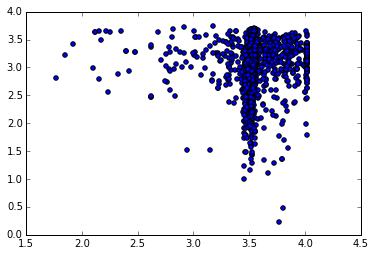

In [40]:
plt.scatter(np.log10(X_new[:,0]),np.log10(X_new[:,1]))

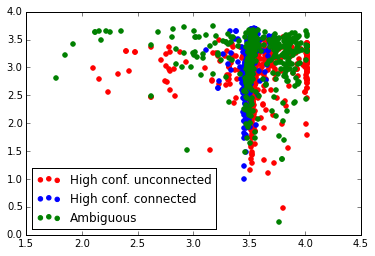

In [41]:
fig, ax = plt.subplots()
ax.scatter(np.log10(X_new[HighClass1,0]),np.log10(X_new[HighClass1,1]), color='r')
ax.scatter(np.log10(X_new[HighClass2,0]),np.log10(X_new[HighClass2,1]), color='b')
ax.scatter(np.log10(X_new[Ambig,0]),np.log10(X_new[Ambig,1]), color='g')
plt.legend(['High conf. unconnected','High conf. connected','Ambiguous'],loc=3)

In [42]:
#plot true labels on a PCA plot 
kpca = PCA(n_components=2)
X_new2 = kpca.fit_transform(X)
print X_new2

[[-2.41093324 -0.51337545]
 [ 2.29387842 -1.32697802]
 [-0.82153336 -0.36831136]
 ..., 
 [-0.79329365 -0.09903899]
 [-0.78369118 -0.13992529]
 [ 2.45522613 -0.25946271]]


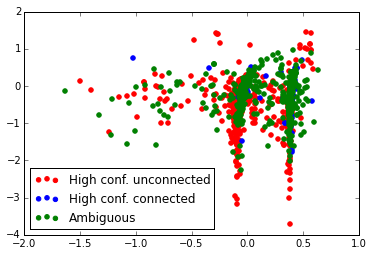

In [43]:
fig, ax = plt.subplots()
ax.scatter(np.log10(X_new2[HighClass1,0]),np.log10(X_new2[HighClass1,1]), color='r')
ax.scatter(np.log10(X_new2[HighClass2,0]),np.log10(X_new2[HighClass2,1]), color='b')
ax.scatter(np.log10(X_new2[Ambig,0]),np.log10(X_new2[Ambig,1]), color='g')
plt.legend(['High conf. unconnected','High conf. connected','Ambiguous'],loc=3)

In [44]:
#calculate efficiency in non-ambiguous
NonAmbigIn = np.logical_or(HighClass1, HighClass2)
print svmc.score(Xp[NonAmbigIn], y[NonAmbigIn])
svmc_pred = svmc.predict(Xp[NonAmbigIn])
print precision_score(y[NonAmbigIn], svmc_pred)
print recall_score(y[NonAmbigIn], svmc_pred)


0.984079023823
0.981434599156
0.910015649452


In [45]:
#calculate efficiency ambiguous
print svmc.score(Xp[Ambig], y[Ambig])
svmc_pred = svmc.predict(Xp[Ambig])
print precision_score(y[Ambig], svmc_pred)
print recall_score(y[Ambig], svmc_pred)


0.834970530452
0.859357696567
0.787817258883


In [46]:
len(Xp) - len(Xp[Ambig])

8605

### Mark points on map as ambiguous and non-ambiguous

In [47]:
NonAmbiI = X[np.logical_or(HighClass1, HighClass2)]
Ambi = X[Ambig]

print NonAmbi.shape
print Ambi.shape

(8605, 12)
(2036, 12)


In [48]:
# Export errors as geojson for visualizing on github
import json
from shapely import wkt
from shapely.geometry import mapping
svmc_pred = svmc.predict(Xp)

geojson = {}
geojson['type'] = 'FeatureCollection'
geojson['features'] = []

for i in range(len(y)):
    feature = {}
    feature['type'] = 'Feature'
    geom = wkt.loads(near_line[i])
    feature['geometry'] = mapping(geom)
    if Ambig[i]:
        if y[i]==1:
            properties = {'actually': 1,
                          'type': 'Ambiguous',
                          'stroke': '#FC0000',
                          'stroke-width': 5}
        else:
            properties = {'actually': 0,
                          'type': 'Ambiguous',
                          'stroke': '#093CA8',
                          'stroke-width': 5}

        
        feature['properties'] = properties
        geojson['features'].append(feature)
        
with open('./AmbiguousLabels.geojson', 'w') as f:
    json.dump(geojson, f)

In [50]:
#see fraction of ambiguous 1's 
Ambig1 = sum(y[Ambig])/sum(y)
print Ambig1
#fraction of unambiguous 1's 
print 1- Ambig1

0.43526292532


In [54]:
#fraction of ambiguous 0's 
Ambig0 = sum(y[Ambig]==0)/len(y==0)
print Ambig0

0.0987689126962


In [55]:
print sum(y[Ambig])/len(y[Ambig])

0.483791748527


In [57]:
len(y[Ambig])

2036